In [1]:
import Classification_Utils as cu
import numpy as np
from os import listdir
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.externals import joblib

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from matplotlib.lines import Line2D

In [3]:
DPI=500 # Constant value to set resolution

## Load and clean data
* One data frame for all training and test data
* One data frame for healthy vs diseased comparison
* One data frame for all training and test data, with the addition of 10 cell line datasets

In [4]:
train_test_df = pd.read_csv('FullPeptideQuant.txt', sep='\t', index_col='Peptide')
print(train_test_df.shape)

healthy_diseased_df = pd.read_csv('HealthyDiseasedQuant.txt', sep='\t', index_col='Peptide')
print(healthy_diseased_df.shape)

tt_cell_line_df = pd.read_csv('TrainTestCellLineQuant.txt', sep='\t', index_col='Peptide')
print(tt_cell_line_df.shape)

(55676, 253)
(43434, 149)
(57887, 263)


## Train/Test data

### Map each column to a corresponding label

In [5]:
train_test_tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']

train_test_tissues_to_columns = cu.map_tissues_to_columns(train_test_df, train_test_tissues)

In [6]:
train_test_column_names = train_test_df.columns.values.tolist()

train_test_labels = cu.get_labels(train_test_column_names, 
                                  train_test_tissues_to_columns)

### Map columns to colors, and prepare PCA dataframe

In [7]:
import seaborn as sns

"""
Creates a dictionary mapping each column name to a color.

Args:
    tissues (list of strings): All tissues in the dataframe
    tissues_to_columns (dictionary): Mapping of each tissue to all associated column names
    palette (string): Color palette to use
"""
def map_colors(tissues, tissues_to_columns, palette='hls'):
    
    color_dict = {} # Column name : color
    num_colors = len(tissues) # One color for each tissue
    colors = sns.color_palette(palette, num_colors)
    
    color = 0

    for tissue in tissues:
        cols = tissues_to_columns[tissue] # Get the list of column names for the tissue 
        for col in cols:
            color_dict[col] = colors[color]
        color += 1
        
    return color_dict

In [22]:
train_test_dir = r'D:\Images\Human_Tissues\\'

tt_color_dict = map_colors(train_test_tissues, train_test_tissues_to_columns)

In [9]:
train_test_T = train_test_df.T  #Transpose data frame

# For 2 dimensional PCA
pca = PCA() # create a PCA object
pca.fit(train_test_T) # do the math
pca_data = pca.transform(train_test_T) # get PCA coordinates for dataframe

# For 3 dimensional PCA
pca_3 = PCA(n_components=3) 
pca_3.fit(train_test_T)
pca_data_3 = pca_3.transform(train_test_T)

# per_var: array containing each principal component's percentage of explained variance
per_var = np.round(pca.explained_variance_ratio_* 100, decimals = 1)
pca_labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 

per_var_3 = np.round(pca_3.explained_variance_ratio_* 100, decimals = 1)
pca_labels_3 = ['PC' + str(x) for x in range(1, len(per_var_3)+1)] 

### 3D PCA of Train and Test

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def draw_3d_pca(column_names, pca_data, base_dir, color_dict, per_var, labels, tissues, tissues_to_columns, title='3D PCA'):
    
    plt.figure()
    
    pca_df = pd.DataFrame(pca_data, index = column_names, columns = labels)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for column in column_names:
        ax.scatter(pca_df.PC1.loc[column], pca_df.PC2.loc[column], pca_df.PC3.loc[column], color=color_dict[column])

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    
    new_handles = []
    for tissue in tissues:
        col = tissues_to_columns[tissue][0]
        color = color_dict[col]
        patch = mpatches.Patch(color=color, label=tissue.replace("_", " "))
        new_handles.append(patch)

    lgd = ax.legend(handles=new_handles, loc=2, bbox_to_anchor=(1.05, 1), ncol=1)
    output_path = base_dir + title + '.pdf'
    fig.savefig(output_path, bbox_inches="tight", bbox_extra_artists=(lgd,), dpi=DPI)
    fig.clf()

In [ ]:
draw_3d_pca(train_test_column_names, pca_data_3, train_test_dir, 
            tt_color_dict, per_var_3, pca_labels_3, 
            train_test_tissues, train_test_tissues_to_columns, '3D PCA')

### Plot train and test data, zoomed-in on tight clustering (Figure XX2)

In [ ]:
train_test_pca_df = pd.DataFrame(pca_data, index = train_test_column_names, columns = pca_labels)

fig = plt.figure(1)

ax = fig.add_subplot(111)

plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for column in train_test_pca_df.index:
    plt.scatter(train_test_pca_df.PC1.loc[column], train_test_pca_df.PC2.loc[column], 
                color = tt_color_dict[column])

# Plot again in zoomed sub-plot
axins = zoomed_inset_axes(ax, 6, loc='center right') # axes, zoom-factor, location
for column in train_test_pca_df.index:
    axins.scatter(train_test_pca_df.PC1.loc[column], train_test_pca_df.PC2.loc[column], 
                  color = tt_color_dict[column])

x1, x2, y1, y2 = -610, -410, 0, -230 # specify the axis limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y2, y1) # apply the y-limits

plt.yticks(visible=False)
plt.xticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

new_handles = []
for tissue in train_test_tissues:
    col = train_test_tissues_to_columns[tissue][0]
    color = tt_color_dict[col]
    patch = mpatches.Patch(color=color, label=tissue.replace("_", " "))
    new_handles.append(patch)
    
lgd = ax.legend(handles=new_handles, loc=2, bbox_to_anchor=(1, 1), ncol=1)

output_path = train_test_dir + 'Zoomed PCA.pdf'
plt.savefig(output_path, bbox_inches="tight", bbox_extra_artists=(lgd,), dpi=DPI)
plt.clf()

### tSNE

In [ ]:
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection
from sklearn.decomposition import TruncatedSVD

X = train_test_df.T.values.tolist()
y = train_test_labels

xx=[]
for i in range(0,len(X)):
    xx.append((X[i] - np.min(X)) / (np.max(X) - np.min(X)))
X=xx

# "It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount"
svd = TruncatedSVD(n_components=50, n_iter=100, random_state=42)
X_svd = svd.fit_transform(X)  

tsne = manifold.TSNE(random_state=0,perplexity=50,verbose=1,n_iter=1500)
X_tsne = tsne.fit_transform(X_svd)

### Plot the data
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)

col=0
for column in train_test_column_names:
    ax.scatter(X_tsne[col, 0], X_tsne[col, 1], color=tt_color_dict[column])
    col+=1
    
    
### Make Legend

new_handles = []
for tissue in train_test_tissues:
    col = train_test_tissues_to_columns[tissue][0]
    color = tt_color_dict[col]
    patch = mpatches.Patch(color=color, label=tissue.replace("_", " "))
    new_handles.append(patch)
    
lgd = ax.legend(handles=new_handles, loc=2, bbox_to_anchor=(1, 1), ncol=1)    

plt.show()

output_path = train_test_dir + 'tSNE.pdf'
fig.savefig(output_path, bbox_inches="tight", bbox_extra_artists=(lgd,), dpi=DPI)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 253 samples in 0.000s...
[t-SNE] Computed neighbors for 253 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 253 / 253
[t-SNE] Mean sigma: 10.978519
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.012878
[t-SNE] Error after 1500 iterations: 0.131320


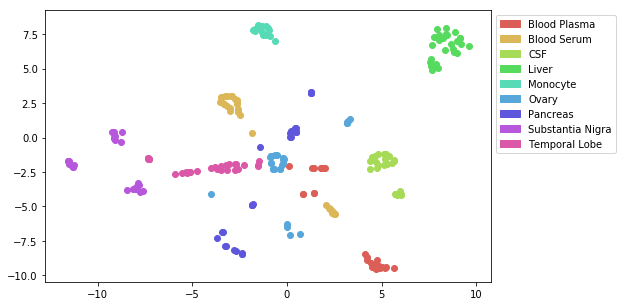

In [33]:
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection
from sklearn.decomposition import TruncatedSVD

X = train_test_df.T.values.tolist()
y = train_test_labels

xx=[]
for i in range(0,len(X)):
    xx.append((X[i] - np.min(X)) / (np.max(X) - np.min(X)))
X=xx

# "It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount"
svd = TruncatedSVD(n_components=100, n_iter=100, random_state=42)
X_svd = svd.fit_transform(X)  

tsne = manifold.TSNE(random_state=0,perplexity=50,verbose=1,n_iter=1500)
X_tsne = tsne.fit_transform(X_svd)

### Plot the data
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)

col=0
for column in train_test_column_names:
    ax.scatter(X_tsne[col, 0], X_tsne[col, 1], color=tt_color_dict[column])
    col+=1
    
    
### Make Legend
new_handles = []
for tissue in train_test_tissues:
    col = train_test_tissues_to_columns[tissue][0]
    color = tt_color_dict[col]
    patch = mpatches.Patch(color=color, label=tissue.replace("_", " "))
    new_handles.append(patch)
    
lgd = ax.legend(handles=new_handles, loc=2, bbox_to_anchor=(1, 1), ncol=1)    

plt.show()

## Healthy and Diseased Data

### Map each column to a corresponding label

In [11]:
def remove_prefix(col_names):
    new_names = []
    
    for name in col_names:
        if name.startswith('Diseased_'):
            new_names.append(name.replace('Diseased_', ''))
        elif name.startswith('Healthy_'):
            new_names.append(name.replace('Healthy_', ''))
        else:
            new_names.append(name)
            
    return new_names

In [12]:
# Remove "Healthy_" or "Diseased_" prefix from column names
original_healthy_diseased_col_names = healthy_diseased_df.columns.values.tolist()

stripped_col_names = remove_prefix(original_healthy_diseased_col_names)
healthy_diseased_df.columns = stripped_col_names

In [13]:
healthy_diseased_tissues = ['Blood_Plasma', 'Liver', 'Pancreas', 'Substantia_Nigra', 'CSF']
healthy_diseased_tissues_to_columns = cu.map_tissues_to_columns(healthy_diseased_df,
                                                                healthy_diseased_tissues)

In [14]:
healthy_diseased_column_names = healthy_diseased_df.columns.values.tolist()
healthy_diseased_labels = cu.get_labels(healthy_diseased_column_names, 
                                        healthy_diseased_tissues_to_columns)

### Map columns to colors, and prepare PCA dataframe

In [18]:
healthy_diseased_dir = r'D:\Images\Healthy_vs_Diseased\\'

hd_color_dict = map_colors(healthy_diseased_tissues, 
                                              healthy_diseased_tissues_to_columns)

In [16]:
healthy_diseased_T = healthy_diseased_df.T  #Transpose data frame

healthy_diseased_pca = PCA() # create a PCA object
healthy_diseased_pca.fit(healthy_diseased_T) # do the math
healthy_diseased_pca_data = healthy_diseased_pca.transform(healthy_diseased_T) # get PCA coordinates for dataframe

healthy_diseased_per_var = np.round(healthy_diseased_pca.explained_variance_ratio_* 100, decimals = 1)
healthy_diseased_pca_labels = ['PC' + str(x) for x in range(1, len(healthy_diseased_per_var)+1)] 

### Plot Healthy vs Diseased (Figure XX3)
Empty circles represent diseased tissues, filled circles represent healthy

In [ ]:
hd_pca_df = pd.DataFrame(healthy_diseased_pca_data, index = original_healthy_diseased_col_names, 
                         columns = healthy_diseased_pca_labels)

fig = plt.figure(1)
ax = fig.add_subplot(111)

plt.xlabel('PC1 - {0}%'.format(healthy_diseased_per_var[0]))
plt.ylabel('PC2 - {0}%'.format(healthy_diseased_per_var[1]))

for column, stripped_col in zip(original_healthy_diseased_col_names, stripped_col_names):
    fill = 'none' if column.startswith('Diseased') else hd_color_dict[stripped_col]
    ax.scatter(hd_pca_df.PC1.loc[column], 
               hd_pca_df.PC2.loc[column],
               color=hd_color_dict[stripped_col], facecolors=fill)
    
output_path = healthy_diseased_dir + 'PCA.pdf'

### Legend entries for each tissue
new_handles = []

for tissue in healthy_diseased_tissues:
    col = healthy_diseased_tissues_to_columns[tissue][0]
    color = hd_color_dict[col]
    patch = mpatches.Patch(color=color, label=tissue.replace('_', ' '))
    line = Line2D(range(1), range(1), color="white", mec=color, marker='o', markerfacecolor=color,
                  label=tissue)
    new_handles.append(patch)

### Append legend entries for open/closed circles (diseased/healthy)
blank_line = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="white")
open_circle = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="black",
                     mec='black', label='Closed Circles: Healthy')
closed_circle = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="white",
                       mec='black', label='Open Circles: Diseased')

new_handles.append(blank_line)
new_handles.append(open_circle)
new_handles.append(closed_circle)
    
### Zoom in on tightly clustered section
axins = zoomed_inset_axes(ax, 10.5, loc='upper right') # axes, zoom-factor, location

for column, stripped_col in zip(original_healthy_diseased_col_names, stripped_col_names):
    fill = 'none' if column.startswith('Diseased') else hd_color_dict[stripped_col]
    axins.scatter(hd_pca_df.PC1.loc[column], 
                  hd_pca_df.PC2.loc[column], 
                  color=hd_color_dict[stripped_col], facecolors=fill)

x1, x2, y1, y2 = -775, -600, -315, -180 # specify the axis limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.yticks(visible=False)
plt.xticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
lgd = ax.legend(handles=new_handles, loc=2, bbox_to_anchor=(1, 1), ncol=1, prop={'size': 7})

### Adjust figure size before saving
inches = (2250/DPI, 2000/DPI)
fig.set_size_inches(inches)

fig.savefig(output_path, bbox_inches="tight", bbox_extra_artists=(lgd,), dpi=DPI)
fig.clf()

### tSNE
* Modified from https://github.com/RubensZimbres/Repo-2017/blob/master/t-SNE%20Dimensionality%20Reduction

In [ ]:
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection
from sklearn.decomposition import TruncatedSVD

X = healthy_diseased_df.T.values.tolist()
y = healthy_diseased_labels

xx=[]
for i in range(0,len(X)):
    xx.append((X[i] - np.min(X)) / (np.max(X) - np.min(X)))
X=xx

# "It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount"
svd = TruncatedSVD(n_components=50, n_iter=100, random_state=42)
X_svd = svd.fit_transform(X)  

tsne = manifold.TSNE(random_state=0,perplexity=50,verbose=1,n_iter=1500)
X_tsne = tsne.fit_transform(X_svd)

### Plot the data
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)

col=0
for column, stripped_col in zip(original_healthy_diseased_col_names, stripped_col_names):
    fill = 'none' if column.startswith('Diseased') else hd_color_dict[stripped_col]
    ax.scatter(X_tsne[col, 0], X_tsne[col, 1], edgecolors=hd_color_dict[stripped_col], facecolors=fill)
    col+=1
    
    
### Make Legend
new_handles = []

for tissue in healthy_diseased_tissues:
    col = healthy_diseased_tissues_to_columns[tissue][0]
    color = hd_color_dict[col]
    patch = mpatches.Patch(color=color, label=tissue.replace("_", " "))
    line = Line2D(range(1), range(1), color="white", mec=color, marker='o', markerfacecolor=color,
                  label=tissue)
    new_handles.append(patch)

### Append legend entries for open/closed circles (diseased/healthy)
blank_line = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="white")
open_circle = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="black",
                     mec='black', label='Closed Circles: Healthy')
closed_circle = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="white",
                       mec='black', label='Open Circles: Diseased')

new_handles.append(blank_line)
new_handles.append(open_circle)
new_handles.append(closed_circle)
    
lgd = ax.legend(handles=new_handles, loc=2, bbox_to_anchor=(1, 1), ncol=1)    

plt.show()

## Cell Line Data 

### Map each column to a corresponding label

In [ ]:
tt_cell_line_tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe', 'Cell_Line']

tt_cell_line_tissues_to_columns = cu.map_tissues_to_columns(tt_cell_line_df, tt_cell_line_tissues)

In [ ]:
tt_cell_line_column_names = tt_cell_line_df.columns.values.tolist()
tt_cell_line_labels = cu.get_labels(tt_cell_line_column_names, tt_cell_line_tissues_to_columns)

### Map columns to colors, and prepare PCA data frames

In [ ]:
cell_line_dir = r'D:\Images\Cell_Line\\'

tt_cell_line_column_to_color = map_colors(tt_cell_line_tissues, 
                                          tt_cell_line_tissues_to_columns, 
                                          'Set3')

In [ ]:
tt_cell_line_T = tt_cell_line_df.T  #Transpose data frame

# For 2 dimensional PCA
tt_cell_line_pca = PCA() # create a PCA object
tt_cell_line_pca.fit(tt_cell_line_T) # do the math
tt_cell_line_pca_data = tt_cell_line_pca.transform(tt_cell_line_T) # get PCA coordinates for dataframe

tt_cell_line_per_var = np.round(tt_cell_line_pca.explained_variance_ratio_* 100, decimals = 1)
tt_cell_line_pca_labels = ['PC' + str(x) for x in range(1, len(tt_cell_line_per_var)+1)] 

### PCA of all train and test tissues with liver cell line samples

In [ ]:
def draw_2d_pca(column_names, pca_data, base_dir, 
                color_dict, per_var, labels, 
                tissues, tissues_to_columns):
    
    pca_df = pd.DataFrame(pca_data, index = column_names, columns = labels)

    fig = plt.figure(1)
    ax = fig.add_subplot(111)

    plt.xlabel('PC1 - {0}%'.format(per_var[0]))
    plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
    for column in column_names:
        ax.scatter(pca_df.PC1.loc[column], pca_df.PC2.loc[column], color=color_dict[column])
        
    output_path = base_dir + 'PCA.pdf'
    
    new_handles = []
    for tissue in tissues:
        col = tissues_to_columns[tissue][0]
        color = color_dict[col]
        patch = mpatches.Patch(color=color, label=tissue.replace("_", " "))
        new_handles.append(patch)
    
    lgd = ax.legend(handles=new_handles, loc=2, bbox_to_anchor=(1, 1), ncol=1)
    fig.savefig(output_path, bbox_inches="tight", bbox_extra_artists=(lgd,), dpi=DPI)
    fig.clf()

In [ ]:
draw_2d_pca(tt_cell_line_column_names, tt_cell_line_pca_data, cell_line_dir, 
            tt_cell_line_column_to_color, tt_cell_line_per_var, tt_cell_line_pca_labels, 
            tt_cell_line_tissues, tt_cell_line_tissues_to_columns)